# 1.使用神经网络对手写数字做分类

## 1.Mnist数据集
MNIST数据集改编自美国国家标准与技术研究所收集的NIST数据集。该数据集收集了来自250个不同人手写的数字图片，其中一半是人口普查局的工作人员，另一半是高中生。该数据集包括50000张训练集图片和10000张测试集图片，训练集和测试集都提供了正确答案。每张图片都是28×28=784大小的灰度图片，也就是一个28×28的矩阵，里面每个值是一个像素点，值在[0,1]之间，其中0表示白色，1表示黑色。

### 1.读取Mnist数据集
pkl是python内置的一种格式，可以将python的各种数据结构序列化存储到磁盘中，需要时又可以读取并反序列化到内存中。mnist.pkl.gz做了两次操作，先pkl序列化，再gz压缩存储，所以要读取该文件，需要先解压再反序列化。

In [54]:
import pickle
import gzip
from pathlib import Path

DATA_PATH = Path("../data")
PATH = DATA_PATH / "mnist"
FILENAME = "mnist.pkl.gz"

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [55]:
# x_train训练样本，是一个50000×784的矩阵，表示有50000个训练样本，每个训练样本是一个784的一维数组，784就是把一张28×28的图片展开成的一维数组
print(f"x_train:{x_train}")
print(f"x_train.shape:{x_train.shape}") # shape获取 矩阵的维度属性
# x_train训练样本对应的识别答案
print(f"y_train:{y_train}")
print(f"y_train.shape:{y_train.shape}")
print("\n")
print(f"x_valid:{x_valid}")
print(f"x_valid.shape:{x_valid.shape}")
print(f"y_valid:{y_train}") 
print(f"y_valid.shape:{y_valid.shape}")



x_train:[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
x_train.shape:(50000, 784)
y_train:[5 0 4 ... 8 4 8]
y_train.shape:(50000,)


x_valid:[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
x_valid.shape:(10000, 784)
y_valid:[5 0 4 ... 8 4 8]
y_valid.shape:(10000,)


### 2.使用matplotlib还原28*28矩阵对应的灰度图片

y_train[:6]:[5 0 4 1 9 2]


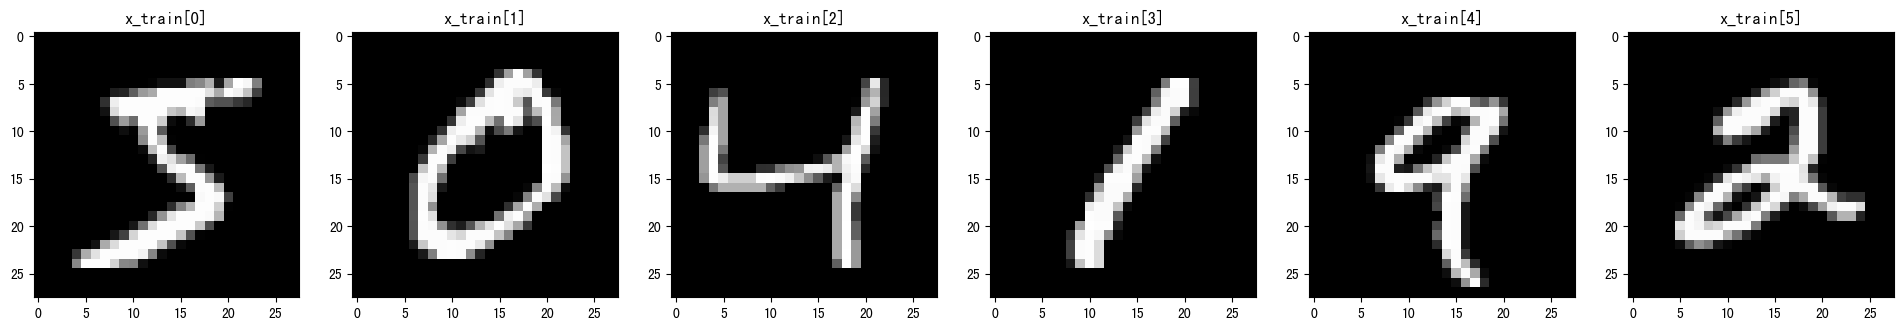

In [56]:
import matplotlib.pyplot as plt

# Plot the data
fig, ax = plt.subplots(1, 6, figsize=(24, 4))

for i in range(6):
    ax[i].imshow(x_train[i].reshape((28, 28)), cmap='gray')
    ax[i].set_title(f'x_train[{i}]')

print(f'y_train[:6]:{y_train[:6]}')

## 2.将数据需转换成tensor以便后续建模训练
Tensor是PyTorch中的基本数据类型，它是一个多维数组，可以用来表示向量、矩阵、甚至是更高维的数据。Tensor类似于Numpy中的数组，但是它可以在GPU上进行计算，从而加速计算过程。

在PyTorch中，我们可以使用Tensor来构建神经网络。通过多层Tensor的组合和非线性变换，我们可以实现复杂的非线性映射关系，从而对数据进行分类、识别、聚类等操作。

与Numpy中的数组类似，Tensor可以使用各种各样的操作进行计算，例如加法、乘法、矩阵乘法等。此外，PyTorch还提供了许多高级的操作，例如卷积、池化等等，可以方便地构建深度学习模型。


In [57]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

print(f"x_train转换tensor后的结构: {x_train}")
print(x_train.shape)
print(f"y_train转换tensor后的结构: {y_train}")
print(y_train.shape)


x_train转换tensor后的结构: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([50000, 784])
y_train转换tensor后的结构: tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000])


## 3.创建模型
1. FC = Wx+B：FC代表全连接层，表示输入向量x通过权重矩阵W进行线性变换，并加上偏差向量B，最终得到全连接层的输出。
2. nn.Module：用于定义神经网络的层、激活函数、损失函数等组件，可以方便地构建自定义神经网络。每个nn.Module实例都有一个forward方法，用于定义数据在神经网络中的正向传播过程。通过继承nn.Module类并实现forward方法，我们可以构建自己的神经网络。
3. nn.Linear：用于定义全连接层。它有两个参数`in_features`和`out_features`，分别表示输入特征的维度和输出特征的维度。通过实例化Linear，我们可以方便地构建全连接层，并将其作为神经网络的一部分来训练。
4. dropout：在训练过程中随机丢弃一部分神经元的输出来减少过拟合，一般每个全连接层都要加一个dropout。
5. F.relu：激活函数，负责将神经元的输入转换为输出。


In [67]:
from torch import nn
import torch.nn.functional as F

class Mnist_NN(nn.Module): # 继承nn.Module
    def __init__(self):
        super().__init__()

        self.hidden1 = nn.Linear(784, 128) # 全连接层1  输入784个像素点 输出128个特征
        self.hidden2 = nn.Linear(128, 256) # 全连接层2 输入128 输出256
        self.dropout = nn.Dropout(0.5) # 随机杀死一半，防止过拟合
        self.out = nn.Linear(256, 10) # 输出层  输入256 输出10个类别分别的概率

    # 前向传播
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

# 打印参数  
for name, parameter in Mnist_NN().named_parameters():
    print(f"参数名字:{name}, 参数矩阵的大小{parameter.size()}")

参数名字:hidden1.weight, 参数矩阵的大小torch.Size([128, 784])
参数名字:hidden1.bias, 参数矩阵的大小torch.Size([128])
参数名字:hidden2.weight, 参数矩阵的大小torch.Size([256, 128])
参数名字:hidden2.bias, 参数矩阵的大小torch.Size([256])
参数名字:out.weight, 参数矩阵的大小torch.Size([10, 256])
参数名字:out.bias, 参数矩阵的大小torch.Size([10])


## 4.打包数据：TensorDataset和DataLoader
1. TensorDataset：是一个用于包装张量的类，可以将多个张量打包成一个数据集。例如，我们可以将训练数据和对应的标签打包成一个TensorDataset对象，便于后续的数据处理和模型训练。
2. DataLoader：是一个用于加载数据的类，可以从TensorDataset对象中加载数据，并将其转换为可用于训练的批量数据。DataLoader类的实例可以指定批量大小、数据的采样方式、数据的并行加载方式等参数，可以方便地处理大规模数据集，并加速模型训练的过程。

在PyTorch中，通常使用TensorDataset和DataLoader配合使用，以便在训练过程中高效地加载和处理数据。具体来说，我们可以先将数据和标签打包成一个TensorDataset对象，然后使用DataLoader类来加载数据，并在训练过程中逐批地处理数据。这样可以方便地处理大规模数据集，并加速模型训练的过程。

In [71]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

bs = 64 # 每次迭代训练的样本数

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


for xb, yb in train_dl:
    print(xb.shape) # 把数据打包成64大小的包
    print(yb.shape)
    break

torch.Size([64, 784])
torch.Size([64])


## 5. 训练
优化器
    1. optim.Adam：是一种常用的随机梯度下降算法，具有自适应学习率和动量的特点，可以在处理大规模数据集和高维参数空间时保持良好的性能。
    2. optim.SGD：用于实现随机梯度下降优化算法。在SGD算法中，每次迭代时，我们随机选择一个样本或一批样本，并使用其梯度来更新模型的参数。通过使用随机梯度下降算法，我们可以逐渐优化模型的参数，并使其逼近最优解。

In [73]:
# zip用法
a = [1, 2, 3]
b = [4, 5, 6]
# 打包
zipped = zip(a, b)
print(zipped)
print(list(zipped)) 

a2, b2 = zip(*zip(a, b))
print(a2)
print(b2)

[(1, 4), (2, 5), (3, 6)]
(1, 2, 3)
(4, 5, 6)


In [75]:
import numpy as np
from torch import optim

def get_model():
    model = Mnist_NN()
    # 返回模型和优化器，
    return model, optim.Adam(model.parameters(), lr=0.001)

def loss_batch(model, loss_func, xb, yb, opt=None):
    # 计算损失
    loss = loss_func(model(xb), yb) # model(xb) 预测值 yb 真实值

    if opt is not None: # 更新模型参数
        loss.backward() # 更新梯度
        opt.step() # 更新
        opt.zero_grad() # 单次更新完梯度置0 每次迭代独立去操作

    return loss.item(), len(xb)

# 训练
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    """
        steps 迭代多少次  
        model 模型 
        loss_func 损失函数 
        opt 优化器
        train_dl 训练打包器
        valid_dl 验证打包器
    """
    for step in range(steps):
        model.train() # 训练, 更新每一层的w、b
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval() # 验证
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        # 平均损失
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))


train_dl, valid_dl = get_data(train_ds, valid_ds, bs) # 数据
model, opt = get_model() # 模型
loss_func = F.cross_entropy # 损失函数 = 交叉熵
fit(30, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：0.179599929356575
当前step:1 验证集损失：0.14357417917847634
当前step:2 验证集损失：0.1121580159522593
当前step:3 验证集损失：0.11041146887615323
当前step:4 验证集损失：0.10470686074495315
当前step:5 验证集损失：0.09232247348800302
当前step:6 验证集损失：0.08791804573275148
当前step:7 验证集损失：0.08908505541421473
当前step:8 验证集损失：0.08694947661794722
当前step:9 验证集损失：0.08461290987851099
当前step:10 验证集损失：0.08025028397841379
当前step:11 验证集损失：0.08384536827770062
当前step:12 验证集损失：0.08306083139716648
当前step:13 验证集损失：0.08150999165521934
当前step:14 验证集损失：0.07832407590104266
当前step:15 验证集损失：0.0829694609716069
当前step:16 验证集损失：0.08271845639846288
当前step:17 验证集损失：0.08078263647994026
当前step:18 验证集损失：0.08001423538625241
当前step:19 验证集损失：0.07657623501101044
当前step:20 验证集损失：0.07512948206283618
当前step:21 验证集损失：0.07732897629848448
当前step:22 验证集损失：0.07818380261892453
当前step:23 验证集损失：0.07927688497276977
当前step:24 验证集损失：0.08269603323438204
当前step:25 验证集损失：0.07786302809547634
当前step:26 验证集损失：0.07405140655671712
当前step:27 验证集损失：0.07921352862792555
当前step

In [76]:
# 计算准确率
correct = 0
total = 0
for xb, yb in valid_dl:
    outputs = model(xb)
    _, predicted = torch.max(outputs.data, 1) # 最大值和索引
    total += yb.size(0)
    correct += (predicted == yb).sum().item()
print("测试集准确率：%d %%" % (100*correct/total))

测试集准确率：97 %
